# DeepSurv with VAE-based Dimensionality Reduction

## Code Implementation of DeepSurv using PyTorch

In [2]:
import random
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from functools import reduce
import operator

import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sklearn.model_selection import StratifiedKFold, ParameterGrid
import shap
import torch.optim as optim
from scipy.interpolate import interp1d

## Neural Network Model Definition for DeepSurv

#### Neural Network Architecture 3-Layer Feedforward

In [3]:
class Net_3layers(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden1=64, hidden2=32, dropout=0.6):
        super(Net_3layers, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden2, output_dim),
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)

#### Neural Network Architecture 5-Layer Feedforward

In [4]:
class Net_5layers(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden1=128, hidden2=64, hidden3=32, hidden4=16, dropout=0.6):
        super(Net_5layers, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden2, hidden3),
            nn.BatchNorm1d(hidden3),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden3, hidden4),
            nn.ReLU(),

            nn.Linear(hidden4, output_dim)
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)

## Configuration Parameters

In [5]:
NUM_FOLDS = 9  # Number of CV folds
SEED = 42  # Random seed for reproducibility
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GENE_STARTS_WITH = ("VAE_")

## Reproducibility Setup

In [6]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

## Paths 

In [7]:
base = os.path.basename(os.getcwd())
list_path = os.getcwd().split(os.sep)
list_path.pop()
ROOT = '\\'.join(list_path)
DATA_PATH = os.path.join(ROOT, 'datasets/preprocessed')
ROOT

'C:\\Users\\giorg\\Documents\\GitHub\\miRNA_&_mRNA'

## Load Data 

In [8]:
dataset_file = 'mRNA/VAE_clinical_mRNA_normalized_tpm_log.csv'
        # 'miRNA/VAE_clinical_miRNA_normalized_log.csv',)
        # 'miRNA/VAE_clinical_miRNA_normalized_quant.csv',
        # 'mRNA/VAE_clinical_mRNA_normalized_log.csv',

In [9]:
dataset_name = os.path.basename(dataset_file).replace(".csv", "")
dataset = pd.read_csv(os.path.join(DATA_PATH, dataset_file))
subtype = dataset_file.split('/')[0]
subtype

'mRNA'

## Prepared Data 

In [10]:
def prepare_data(ds):
    """
    Splits the dataset into feature matrix X and survival targets y.
    Optionally includes or excludes clinical variables.
    """
    y_cols = ['Death', 'days_to_last_followup', 'days_to_death']
    y = ds[['Death', 'days_to_last_followup']].copy()
    y = y.rename(columns={'Death': 'event', 'days_to_last_followup': 'duration'})

    X_cols = [col for col in ds.columns if col not in y_cols]
    X = ds[X_cols].copy()
    return X, y

X, y = prepare_data(dataset)
y.head()

,event,duration
0,1,2763.0
1,1,4456.0
2,1,2520.0
3,1,538.0
4,1,2551.0


In [11]:
gene_cols = [c for c in X.columns if c.startswith('VAE_')]
clinical_cols = [c for c in X.columns if c not in gene_cols]
clinical_cols

['age_at_initial_pathologic_diagnosis',
 'pathologic_stage_Stage I',
 'pathologic_stage_Stage IA',
 'pathologic_stage_Stage IIA',
 'pathologic_stage_Stage IIB',
 'pathologic_stage_Stage IIIA',
 'pathologic_stage_Stage IIIC']

## Stratified K-Fold Cross-Validation Setup

In [12]:
duration_bins = pd.qcut(y['duration'], q=4, labels=False)
stratify_col = y['event'].astype(str) + "_" + duration_bins.astype(str)

kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
fold_indexes = list(kfold.split(X, stratify_col))

In [13]:
def data_to_gpu(X, y, device):
    """
    Converts feature matrix and survival targets to PyTorch tensors
    and moves them to the selected device (CPU/GPU).
    """
    X_np = X.values if hasattr(X, "values") else X
    X_t = torch.tensor(X_np, dtype=torch.float32, device=device)
    y_t = (torch.tensor(y['duration'].to_numpy(dtype='float32'), device=device),
           torch.tensor(y['event'].to_numpy(dtype='float32'), device=device))
    return X_t, y_t
    
X_gpu, y_gpu = data_to_gpu(X, y, DEVICE)

In [14]:
X_train_pca_folds = [X_gpu[train_idx] for train_idx, _ in fold_indexes]
X_val_pca_folds   = [X_gpu[val_idx]   for _, val_idx   in fold_indexes]

## Create model

In [15]:
def create_model(X, params, network_class):
    """
    Instantiates a DeepSurv model (CoxPH) with the specified
    neural network architecture and hyperparameters.
    """
    in_features = X.shape[1]
    if network_class == Net_3layers:
        net = Net_3layers(in_features, 1, params['hidden1'], params['hidden2'], params['dropout'])
    else:
        net = Net_5layers(in_features, 1, params['hidden1'], params['hidden2'], params['hidden3'],
                          params['hidden4'], params['dropout'])

    optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params.get('weight_decay', 1e-4))
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer = optimizer

    return model

## Callbacks

In [16]:
# ------------------ CALLBACKS ------------------
class LrLogger(tt.callbacks.Callback):
    def on_epoch_end(self):
        lr = self.model.optimizer.param_groups[0]['lr']
        print(f"LR = {lr:.6e}")


class DecayLR(tt.callbacks.Callback):
    def __init__(self, lr0, decay_rate=0.003):
        self.lr0 = lr0
        self.decay_rate = decay_rate
        self.epoch = 0

    def on_epoch_start(self):
        epoch = self.epoch
        new_lr = self.lr0 / (1.0 + epoch * self.decay_rate)

        for param_group in self.model.optimizer.param_groups:
            param_group['lr'] = new_lr
        self.epoch += 1

Note: The parameters used in this demo are based on the results of a grid search hyperparameter tuning process conducted on scripts 'deepSurv.py' executed on GPU servers.

In [17]:
json_3_path = os.path.join(ROOT, 'grid_searches', 'deepsurv', subtype, dataset_name, 'gcv_best_results_Net_3layers.json')
json_5_path = os.path.join(ROOT, 'grid_searches', 'deepsurv', subtype, dataset_name, 'gcv_best_results_Net_5layers.json')

import json
with open(json_3_path, 'r') as f:
    json_3 = json.load(f)
    grid_3 = json_3['best_params']
    param_grid_3 = {k: [v] for k, v in grid_3.items()}
    print(param_grid_3)

with open(json_5_path, 'r') as f:
    json_5 = json.load(f)
    grid_5 = json_5['best_params']
    param_grid_5 = {k: [v] for k, v in grid_5.items()}
    print(param_grid_5)

{'batch_size': [32], 'decay_lr': [0.003], 'dropout': [0.3], 'epochs': [500], 'hidden1': [64], 'hidden2': [64], 'lr': [0.01], 'weight_decay': [0.0001]}
{'batch_size': [64], 'decay_lr': [0.003], 'dropout': [0.5], 'epochs': [500], 'hidden1': [128], 'hidden2': [64], 'hidden3': [32], 'hidden4': [16], 'lr': [0.01], 'weight_decay': [1e-05]}


## Grid Search Hyperparameter Tuning Results + Cross-Validation 

In [18]:
def grid_searches(X_train_pca_folds, X_val_pca_folds, y, fold_indexes, network_class, param_grid, device):
    print("=" * 100)
    print(f"Starting grid search for {network_class.__name__}")
    print("=" * 100)

    best_result = {'best_score': -1, 'best_params': None, 'best_model': None}
    total_combs = reduce(operator.mul, (len(v) for v in param_grid.values()))
    results = []

    for i, params in enumerate(ParameterGrid(param_grid), 1):
        cindex_scores = []
        print(f"Testing {i}/{total_combs}".center(100, '-'))
        print(f"Parameters: {params}")

        for (train_idx, val_idx), X_train_pca, X_val_pca in zip(fold_indexes, X_train_pca_folds, X_val_pca_folds):
            X_train_fold = X_train_pca.to(device, dtype=torch.float32)
            X_val_fold = X_val_pca.to(device, dtype=torch.float32)

            y_train_fold = (y[0][train_idx], y[1][train_idx])
            y_val_fold = (y[0][val_idx], y[1][val_idx])

            model = create_model(X_train_fold, params, network_class)

            lr_decay_cb = DecayLR(lr0=params['lr'], decay_rate=params['decay_lr'])
            model.fit(X_train_fold, y_train_fold,
                      batch_size=params['batch_size'], epochs=params['epochs'],
                      callbacks=[
                          tt.callbacks.EarlyStopping(patience=30, file_path=f"/tmp/deepsurv_{network_class.__name__}_{X_train_fold.shape[1]}_{random.random()}.pt"),
                          lr_decay_cb,
                          LrLogger()
                      ],
                      verbose=True, val_data=(X_val_fold, y_val_fold))

            _ = model.compute_baseline_hazards()
            surv_df = model.predict_surv_df(X_val_fold)

            ev = EvalSurv(surv_df,
                          y_val_fold[0].cpu().numpy(),
                          y_val_fold[1].cpu().numpy(),
                          censor_surv='km')

            # C-index
            cindex_scores.append(ev.concordance_td())

        mean_score = np.mean(cindex_scores)

        fold_result = {
            'params': params,
            'mean_concordance': mean_score,
            'std_concordance': np.std(cindex_scores)
        }
        for f in range(len(cindex_scores)):
            fold_result[f"split{f}_c_index"] = cindex_scores[f]
        results.append(fold_result)

        if mean_score > best_result['best_score']:
            best_result = {'best_score': mean_score, 'best_params': params}

        torch.cuda.empty_cache()

    print("\nBest hyperparameters identified.")
    print(f"\tBest concordance index: {best_result['best_score']:.4f}")
    print(f"\tOptimal parameter set: {best_result['best_params']}")

    net_name = network_class.__name__
    results = pd.DataFrame(results)
    print(f"{net_name} - results: {results}")
    
    print(f"{net_name} - best results: {best_result}")

    return best_result, results

In [19]:
print("\nGrid search for best params...")
gcv_best_3, _ = grid_searches(X_train_pca_folds, X_val_pca_folds, y_gpu, fold_indexes, Net_3layers,
                              param_grid_3, DEVICE)


Grid search for best params...
Starting grid search for Net_3layers
--------------------------------------------Testing 1/1---------------------------------------------
Parameters: {'batch_size': 32, 'decay_lr': 0.003, 'dropout': 0.3, 'epochs': 500, 'hidden1': 64, 'hidden2': 64, 'lr': 0.01, 'weight_decay': 0.0001}
LR = 1.000000e-02
0:	[0s / 0s],		train_loss: 2.3196,	val_loss: 2.2160
LR = 9.970090e-03
1:	[0s / 0s],		train_loss: 2.2442,	val_loss: 2.2447
LR = 9.940358e-03
2:	[0s / 0s],		train_loss: 1.9784,	val_loss: 2.3015
LR = 9.910803e-03
3:	[0s / 0s],		train_loss: 1.8319,	val_loss: 2.4130
LR = 9.881423e-03
4:	[0s / 0s],		train_loss: 1.5889,	val_loss: 2.2380
LR = 9.852217e-03
5:	[0s / 0s],		train_loss: 1.5877,	val_loss: 1.9978
LR = 9.823183e-03
6:	[0s / 0s],		train_loss: 1.4432,	val_loss: 2.0317
LR = 9.794319e-03
7:	[0s / 0s],		train_loss: 1.3475,	val_loss: 2.2369
LR = 9.765625e-03
8:	[0s / 0s],		train_loss: 1.1957,	val_loss: 2.0585
LR = 9.737098e-03
9:	[0s / 0s],		train_loss: 1.1890,	

In [20]:
gcv_best_5, _ = grid_searches(X_train_pca_folds, X_val_pca_folds, y_gpu, fold_indexes, Net_5layers,
                              param_grid_5, DEVICE)

Starting grid search for Net_5layers
--------------------------------------------Testing 1/1---------------------------------------------
Parameters: {'batch_size': 64, 'decay_lr': 0.003, 'dropout': 0.5, 'epochs': 500, 'hidden1': 128, 'hidden2': 64, 'hidden3': 32, 'hidden4': 16, 'lr': 0.01, 'weight_decay': 1e-05}
LR = 1.000000e-02
0:	[0s / 0s],		train_loss: 2.9311,	val_loss: 2.6490
LR = 9.970090e-03
1:	[0s / 0s],		train_loss: 3.0536,	val_loss: 2.5207
LR = 9.940358e-03
2:	[0s / 0s],		train_loss: 2.8892,	val_loss: 2.3590
LR = 9.910803e-03
3:	[0s / 0s],		train_loss: 2.8668,	val_loss: 2.2665
LR = 9.881423e-03
4:	[0s / 0s],		train_loss: 2.7398,	val_loss: 2.2340
LR = 9.852217e-03
5:	[0s / 0s],		train_loss: 2.3931,	val_loss: 2.2724
LR = 9.823183e-03
6:	[0s / 0s],		train_loss: 2.4083,	val_loss: 2.3646
LR = 9.794319e-03
7:	[0s / 0s],		train_loss: 2.1947,	val_loss: 2.4844
LR = 9.765625e-03
8:	[0s / 0s],		train_loss: 2.3126,	val_loss: 2.3662
LR = 9.737098e-03
9:	[0s / 0s],		train_loss: 2.3727,	va

## Cross-Validation with grid search best parameters

In [21]:
def cross_validate(X_train_pca_folds, X_val_pca_folds, y, fold_indexes, params, network_class, device):
    print(f"Running cross-validation for {network_class.__name__}\n")
    cindex_scores = []
    brier_scores = []
    times_folds = []
    ibs_scores = []
    models = []

    to_int = {"batch_size", "epochs", "hidden1", "hidden2", "hidden3", "hidden4"}
    params = {
        k: int(v) if k in to_int else v
        for k, v in params.items()
    }

    for fold_idx, ((train_idx, val_idx), X_train_pca, X_val_pca) in enumerate(
            zip(fold_indexes, X_train_pca_folds, X_val_pca_folds)):
        print(f"Training fold {fold_idx + 1}/{len(fold_indexes)}")

        X_train_fold = X_train_pca.to(device, dtype=torch.float32)
        X_val_fold = X_val_pca.to(device, dtype=torch.float32)

        y_train_fold = (y[0][train_idx], y[1][train_idx])
        y_val_fold = (y[0][val_idx], y[1][val_idx])

        # model = create_model(in_features, params, network_class)
        model = create_model(X_train_fold, params, network_class)
        lr_decay_cb = DecayLR(lr0=params['lr'], decay_rate=params['decay_lr'])

        log = model.fit(X_train_fold, y_train_fold,
                        batch_size=params['batch_size'], epochs=params['epochs'],
                        callbacks=[
                            tt.callbacks.EarlyStopping(patience=30),
                            lr_decay_cb
                        ],
                        verbose=True, val_data=(X_val_fold, y_val_fold))

        _ = model.compute_baseline_hazards()
        surv_df = model.predict_surv_df(X_val_fold)

        durations_test = y_val_fold[0].cpu().numpy()
        ev = EvalSurv(surv_df,
                      durations_test,
                      y_val_fold[1].cpu().numpy(),
                      censor_surv='km')

        # C-index
        cindex_scores.append(ev.concordance_td())

        # Brier score
        #time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
        t_max = np.percentile(durations_test, 95)
        time_grid = np.linspace(durations_test.min(), t_max, 100)
        # times = surv_df.index.values
        bs = ev.brier_score(time_grid)
        brier_scores.append(list(bs))
        times_folds.append(list(time_grid))

        # Integrated Brier Score
        ibs = ev.integrated_brier_score(time_grid)
        ibs_scores.append(ibs)

        models.append(model)
        torch.cuda.empty_cache()

    # Times
    times_dict = {f"times_fold{i + 1}": [times_folds[i]] for i in range(len(times_folds))}
    df_times = pd.DataFrame(times_dict)

    rows = []
    for f in range(len(cindex_scores)):
        rows.append({
            "split": f,
            "c_index": cindex_scores[f],
            "brier_score": list(brier_scores[f]),
            "ibs": ibs_scores[f]
        })

    # Show results    
    fold_result = pd.DataFrame(rows)
    print(fold_result)

    return models, fold_result, df_times

In [22]:
print("\nCross validation on best params...")
models_3, cv_results_3, df_times = cross_validate(X_train_pca_folds, X_val_pca_folds, y_gpu, fold_indexes, gcv_best_3['best_params'], Net_3layers, DEVICE)


Cross validation on best params...
Running cross-validation for Net_3layers

Training fold 1/9
0:	[0s / 0s],		train_loss: 2.3331,	val_loss: 2.1612
1:	[0s / 0s],		train_loss: 2.0516,	val_loss: 1.7898
2:	[0s / 0s],		train_loss: 1.8758,	val_loss: 1.9464
3:	[0s / 0s],		train_loss: 1.8599,	val_loss: 2.2041
4:	[0s / 0s],		train_loss: 1.8267,	val_loss: 2.1457
5:	[0s / 0s],		train_loss: 1.6243,	val_loss: 2.0143
6:	[0s / 0s],		train_loss: 1.4275,	val_loss: 1.8811
7:	[0s / 0s],		train_loss: 1.4279,	val_loss: 2.1557
8:	[0s / 0s],		train_loss: 1.3165,	val_loss: 2.2545
9:	[0s / 0s],		train_loss: 1.2038,	val_loss: 2.7389
10:	[0s / 0s],		train_loss: 1.2930,	val_loss: 3.1616
11:	[0s / 0s],		train_loss: 1.3503,	val_loss: 2.5811
12:	[0s / 0s],		train_loss: 1.4992,	val_loss: 2.6733
13:	[0s / 0s],		train_loss: 1.0740,	val_loss: 3.2749
14:	[0s / 0s],		train_loss: 1.3204,	val_loss: 3.0400
15:	[0s / 0s],		train_loss: 0.9907,	val_loss: 2.3555
16:	[0s / 0s],		train_loss: 1.1862,	val_loss: 2.7723
17:	[0s / 0s]

In [23]:
models_5, cv_results_5, _ = cross_validate(X_train_pca_folds, X_val_pca_folds, y_gpu, fold_indexes, gcv_best_5['best_params'], Net_5layers, DEVICE)

Running cross-validation for Net_5layers

Training fold 1/9
0:	[0s / 0s],		train_loss: 3.0492,	val_loss: 2.6327
1:	[0s / 0s],		train_loss: 2.9536,	val_loss: 2.5537
2:	[0s / 0s],		train_loss: 2.8439,	val_loss: 2.4330
3:	[0s / 0s],		train_loss: 2.6718,	val_loss: 2.3245
4:	[0s / 0s],		train_loss: 2.9970,	val_loss: 2.2964
5:	[0s / 0s],		train_loss: 2.6472,	val_loss: 2.2954
6:	[0s / 0s],		train_loss: 2.5700,	val_loss: 2.3282
7:	[0s / 0s],		train_loss: 2.3620,	val_loss: 2.3594
8:	[0s / 0s],		train_loss: 2.5814,	val_loss: 2.4732
9:	[0s / 0s],		train_loss: 2.3311,	val_loss: 2.6557
10:	[0s / 0s],		train_loss: 2.2063,	val_loss: 2.7847
11:	[0s / 0s],		train_loss: 2.4484,	val_loss: 2.9158
12:	[0s / 0s],		train_loss: 2.2235,	val_loss: 2.8246
13:	[0s / 0s],		train_loss: 2.1898,	val_loss: 2.6940
14:	[0s / 0s],		train_loss: 2.1962,	val_loss: 2.6395
15:	[0s / 0s],		train_loss: 2.0740,	val_loss: 2.6952
16:	[0s / 0s],		train_loss: 2.0102,	val_loss: 2.7571
17:	[0s / 0s],		train_loss: 2.3296,	val_loss: 2.7

## Plots

#### C-Index Boxplot, Brier Score Curve, Integrated Brier Score, SHAP Summary Plot

In [24]:
class WrappedNet(torch.nn.Module):
    def __init__(self, net, device):
        super().__init__()
        self.net = net
        self.device = device

    def forward(self, x):
        # Adds an extra output dimension required by SHAP
        x = x.to(self.device)
        return self.net(x).unsqueeze(1)


def explanation_to_gene(ax, models, X_gpu, gene_cols, clinical_cols, top_k=30):
    print("Computing SHAP values...")

    X = X_gpu.detach().float().to(DEVICE)
    all_shap_projected = []

    for model in models:
        net = WrappedNet(model.net, DEVICE).to(DEVICE)
        net.eval()

        bg_idx = np.random.choice(X.shape[0], min(300, X.shape[0]), replace=False)
        background = X[bg_idx]

        explainer = shap.GradientExplainer(net, background)
        shap_values = explainer.shap_values(X)

        if isinstance(shap_values, list):
            shap_values = shap_values[0]

        shap_values = shap_values[:, :, 0]

        if torch.is_tensor(shap_values):
            shap_values = shap_values.detach().cpu().numpy()

        # ---------------- split ----------------
        n_genes = len(gene_cols)
        shap_vae = shap_values[:, :n_genes]
        shap_clinical = shap_values[:, n_genes:]

        shap_full = np.concatenate([shap_vae, shap_clinical], axis=1)
        all_shap_projected.append(shap_full)

        del net
        del explainer
        torch.cuda.empty_cache()

    all_shap_projected = np.array(all_shap_projected)
    mean_abs_shap = np.mean(np.abs(all_shap_projected), axis=(0, 1))

    feature_names = gene_cols + clinical_cols

    df = pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
    }).sort_values("mean_abs_shap", ascending=False)

    # ---------------- plot ----------------
    top = df.head(top_k)[::-1]
    ax.barh(top["feature"], top["mean_abs_shap"], color="steelblue")
    ax.set_title("Top Feature Importances (SHAP)")
    ax.set_xlabel("Mean |SHAP value|")

In [25]:
def plots(models_n, best_res_n, X_gpu, gene_cols, clinical_cols, n=3):
    # LOAD TIMES
    times_folds = []
    for col in df_times.columns:
        str_list = df_times[col].iloc[0]
        times_folds.append(str_list)

    # -----------------------------------------------------------
    # MODEL n-LAYER
    # -----------------------------------------------------------
    print(f"\nPlotting DeepSurv {n}-layer model results.")

    fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)
    ax1, ax2, ax_explain = axes.flatten()
    fig.suptitle(f"Network {n} layers", fontsize=14, fontweight='bold')

    # -----------------------------------------------------------
    # MODEL n-LAYER → BOX C-INDEX
    # -----------------------------------------------------------
    scores_n = best_res_n["c_index"].values

    ax1.boxplot(scores_n, vert=True, patch_artist=True)
    ax1.set_title("C-index distribution across folds")
    ax1.set_ylabel("C-index")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # -----------------------------------------------------------
    # MODEL n-LAYER → BRIER CURVES
    # -----------------------------------------------------------
    brier_scores_n = best_res_n["brier_score"].values
    ibs_folds_n = best_res_n["ibs"].values

    max_common = min(np.max(np.array(t)) for t in times_folds)
    min_common = max(np.min(np.array(t)) for t in times_folds)
    time_grid = np.linspace(min_common, max_common, 300)

    ibs_mean = np.mean(ibs_folds_n)
    ibs_std = np.std(ibs_folds_n)
    ibs_min = np.min(ibs_folds_n)
    ibs_max = np.max(ibs_folds_n)
    ibs_p25 = np.percentile(ibs_folds_n, 25)
    ibs_p50 = np.percentile(ibs_folds_n, 50)
    ibs_p75 = np.percentile(ibs_folds_n, 75)

    for i, (times, bs) in enumerate(zip(times_folds, brier_scores_n)):
        f = interp1d(times, bs, kind='nearest', bounds_error=False, fill_value=np.nan)
        ax2.plot(time_grid, f(time_grid), alpha=0.6, label=f"Fold {i}")

    ax2.set_title("Time-Dependent Brier Score across folds")
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Brier Score")
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle="--", alpha=0.4)

    ax2.text(
        0.02, 0.98,
        f"IBS\n"
        f"mean = {ibs_mean:.4f}\n"
        f"std  = {ibs_std:.4f}\n"
        f"min  = {ibs_min:.4f}\n"
        f"max  = {ibs_max:.4f}\n"
        f"P25 = {ibs_p25:.4f}\n"
        f"P50 = {ibs_p50:.4f}\n"
        f"P75 = {ibs_p75:.4f}",
        transform=ax2.transAxes,
        fontsize=9,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    # -----------------------------------------------------------
    # MODEL n-LAYER → SHAP values
    # -----------------------------------------------------------
    explanation_to_gene(ax_explain, models_n, X_gpu, gene_cols, clinical_cols)
    plt.tight_layout(pad=1.0)
    plt.show()
    plt.close()


Plotting DeepSurv 3-layer model results.
Computing SHAP values...


C:\Users\giorg\AppData\Local\Temp\ipykernel_6504\1337786756.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0)


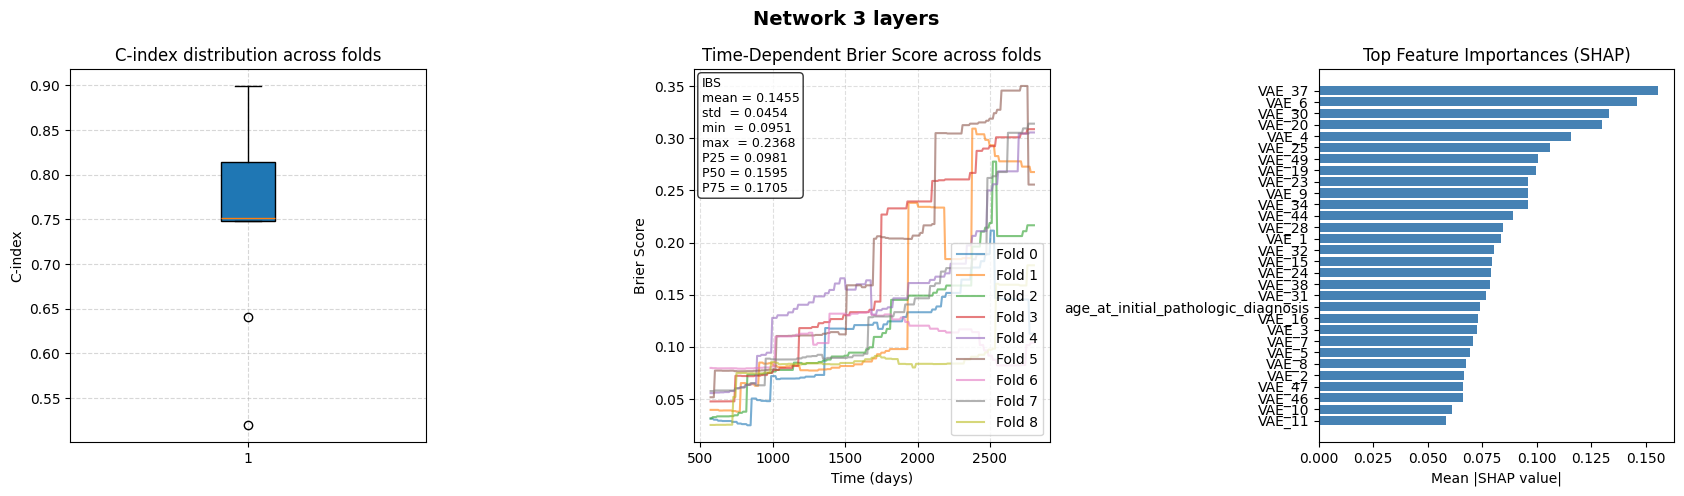

In [27]:
plots(models_3, cv_results_3, X_gpu, gene_cols, clinical_cols, n=3)


Plotting DeepSurv 5-layer model results.
Computing SHAP values...


C:\Users\giorg\AppData\Local\Temp\ipykernel_6504\1337786756.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0)


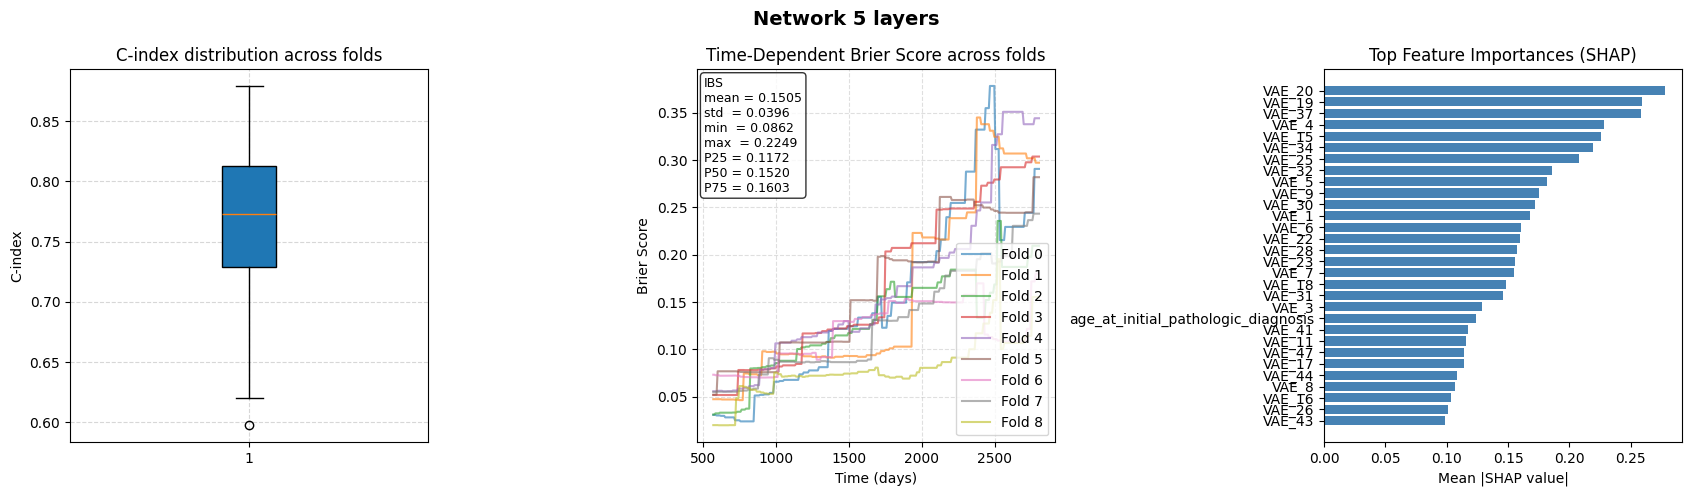

In [28]:
plots(models_5, cv_results_5, X_gpu, gene_cols, clinical_cols, n=5)